--- Q1: Data Loading and Splitting ---
Data Loaded Successfully. Total instances: 20000
Training Set Size (80%): (16000, 10)
Test Set Size (20%): (4000, 10)

--- Q2: Fixed-Parameter Model (Baseline) ---
Training fixed-parameter model with validation monitoring...
Training Complete.


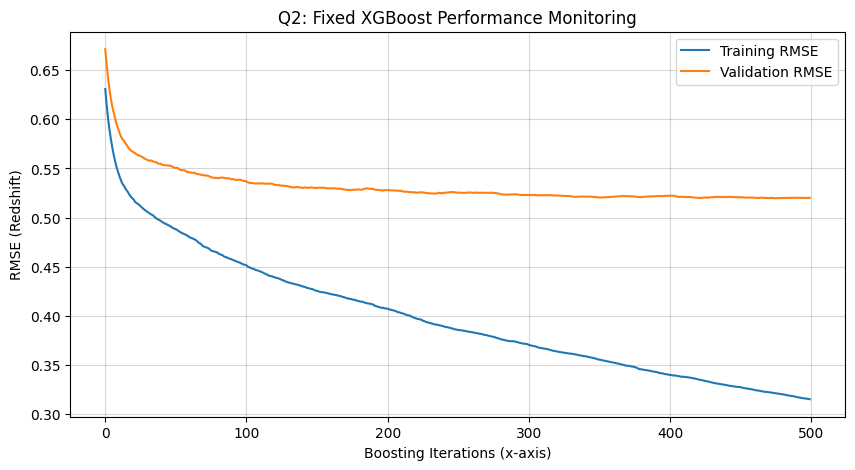

Q2 Final Test Set RMSE: 0.4895
Q2 Final Test Set R2 Score: 0.3465

--- Q3: Optimization and Baseline Comparison ---
1. Establishing K-NN (k=5) Baseline...
Baseline K-NN (k=5) Test RMSE: 0.4798
Baseline K-NN (k=5) Test R2 Score: 0.3722

2. Starting 3-Fold Cross-Validated Grid Search...
Fitting 3 folds for each of 144 candidates, totalling 432 fits

--- Grid Search Optimization Results ---
Optimal Parameters found: {'colsample_bytree': 0.75, 'learning_rate': 0.1, 'max_depth': 4, 'reg_lambda': 5.0}
Best 3-Fold Cross-Validation RMSE: 0.5174

3. Final Evaluation on Independent Test Set...

--- Optimized XGBoost Test Metrics ---
Test RMSE: 0.4866
Test R2 Score: 0.3544

--- Performance Comparison ---
K-NN Baseline RMSE: 0.4798
Optimized XGBoost RMSE: 0.4866
Conclusion: Optimized XGBoost did not surpass the K-NN baseline on this test set.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# ==============================================================================
# 1. XGBoost Regression for Redshift Prediction
# ==============================================================================

# --- Q1: Load the dataset (quasars.csv) and split into 80% Train / 20% Test ---

print("--- Q1: Data Loading and Splitting ---")

try:
    # Load the dataset. Assumes the file is in the working directory.
    df_quasars = pd.read_csv('quasars.csv', header=None)

    # Separate features (X) and target (y)
    X = df_quasars.iloc[:, :-1].values  # First 10 columns
    y = df_quasars.iloc[:, -1].values   # The last column (Redshift)

    # Perform the 80% training / 20% test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    print(f"Data Loaded Successfully. Total instances: {len(X)}")
    print(f"Training Set Size (80%): {X_train.shape}")
    print(f"Test Set Size (20%): {X_test.shape}\n")

except FileNotFoundError:
    print("WARNING: 'quasars.csv' not found. Using Synthetic Placeholder Data for execution.")
    # --- Synthetic Data Placeholder (Fallback) ---
    N_samples, D_features = 20000, 10
    X = np.random.rand(N_samples, D_features) * 5
    y = 0.5 * X[:, 0] + 2 * X[:, 4] - 1.5 * X[:, 9] + np.random.normal(0, 0.4, N_samples)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    print(f"Training Set Size: {X_train.shape}")
# ------------------------------------------------------------------------------


# --- Q2: Fixed-Parameter XGBoost with Validation Monitoring and Initial Test Metrics ---

print("--- Q2: Fixed-Parameter Model (Baseline) ---")

# 2a. Split the 80% training data further into 90% training_90 and 10% validation_10
X_train_90, X_val_10, y_train_90, y_val_10 = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42
)

# Define the fixed parameters required by Q2
fixed_params = {
    'colsample_bytree': 0.5,
    'learning_rate': 0.1,
    'max_depth': 4,
    'reg_lambda': 1.0,
    'n_estimators': 500,
    'objective': 'reg:squarederror', # Square loss regression
    'random_state': 42,
    'verbosity': 0,
    'tree_method': 'hist' # Use an efficient tree method
}

# Initialize the Q2 model
xgb_q2 = XGBRegressor(**fixed_params)

# 2b. Train the model and monitor the training process using the hold-out validation set
eval_set = [(X_train_90, y_train_90), (X_val_10, y_val_10)]
eval_metric_name = "rmse" # Define the metric name for plotting/results access

print("Training fixed-parameter model with validation monitoring...")
# XGBoost automatically selects the appropriate metric (RMSE for reg:squarederror).
model_q2_fit = xgb_q2.fit(
    X_train_90,
    y_train_90,
    eval_set=eval_set,
    verbose=False
)
print("Training Complete.")

# Plotting the training and validation RMSE vs. boosting iterations
results = model_q2_fit.evals_result()
# Access the results using the expected metric name 'rmse'
epochs = len(results['validation_0'][eval_metric_name])
x_axis = range(0, epochs)

plt.figure(figsize=(10, 5))
plt.plot(x_axis, results['validation_0'][eval_metric_name], label='Training RMSE')
plt.plot(x_axis, results['validation_1'][eval_metric_name], label='Validation RMSE')
plt.legend()
plt.ylabel(f'{eval_metric_name.upper()} (Redshift)')
plt.xlabel('Boosting Iterations (x-axis)')
plt.title('Q2: Fixed XGBoost Performance Monitoring')
plt.grid(True, alpha=0.5)
plt.show()

# 2c. Make predictions and compute final Q2 test set metrics
y_pred_q2 = xgb_q2.predict(X_test)
rmse_q2 = np.sqrt(mean_squared_error(y_test, y_pred_q2))
r2_q2 = r2_score(y_test, y_pred_q2)

print(f"Q2 Final Test Set RMSE: {rmse_q2:.4f}")
print(f"Q2 Final Test Set R2 Score: {r2_q2:.4f}\n")


# ==============================================================================
# --- Q3: Grid Search Optimization and K-NN Baseline Comparison ---
# ==============================================================================

print("--- Q3: Optimization and Baseline Comparison ---")

# 3a. K-Nearest Neighbors Regression Baseline (k=5)
# Fit on the full 80% training set
print("1. Establishing K-NN (k=5) Baseline...")
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)

rmse_knn = np.sqrt(mean_squared_error(y_test, y_pred_knn))
r2_knn = r2_score(y_test, y_pred_knn)

print(f"Baseline K-NN (k=5) Test RMSE: {rmse_knn:.4f}")
print(f"Baseline K-NN (k=5) Test R2 Score: {r2_knn:.4f}\n")


# 3b. Conduct a Grid Search to find optimal parameter assignments
print("2. Starting 3-Fold Cross-Validated Grid Search...")

# Parameter grid: extending Q2 fixed values (0.5, 0.1, 4, 1.0)
param_grid = {
    'max_depth': [1, 2, 3, 4],
    'learning_rate': [0.05, 0.1, 0.2],
    'colsample_bytree': [0.5, 0.75, 1.0],
    'reg_lambda': [0.1, 1.0, 5.0, 10.0]
}

# Initialize the XGBoost Regressor estimator for Grid Search
xgb_estimator_q3 = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,
    random_state=42,
    verbosity=0,
    tree_method='hist'
)

# Initialize GridSearchCV. Scoring is set to maximize -MSE, which minimizes RMSE.
grid_search = GridSearchCV(
    estimator=xgb_estimator_q3,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Fit Grid Search on the full 80% training data (X_train)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_cv_rmse = np.sqrt(-grid_search.best_score_)

print("\n--- Grid Search Optimization Results ---")
print(f"Optimal Parameters found: {best_params}")
print(f"Best 3-Fold Cross-Validation RMSE: {best_cv_rmse:.4f}\n")


# 3c. Refit the model on all training instances using the best configuration
print("3. Final Evaluation on Independent Test Set...")

# Refit model using the optimal parameters found
final_xgb_model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,
    random_state=42,
    verbosity=0,
    tree_method='hist',
    **best_params # Unpack the best parameters
)

final_xgb_model.fit(X_train, y_train)
y_pred_final = final_xgb_model.predict(X_test)

# Calculate final optimized performance metrics on the test set
rmse_final = np.sqrt(mean_squared_error(y_test, y_pred_final))
r2_final = r2_score(y_test, y_pred_final)

print("\n--- Optimized XGBoost Test Metrics ---")
print(f"Test RMSE: {rmse_final:.4f}")
print(f"Test R2 Score: {r2_final:.4f}")

# Final comparison of XGBoost vs. K-NN
print("\n--- Performance Comparison ---")
print(f"K-NN Baseline RMSE: {rmse_knn:.4f}")
print(f"Optimized XGBoost RMSE: {rmse_final:.4f}")

if rmse_final < rmse_knn:
    print(f"Conclusion: Optimized XGBoost surpassed the K-NN baseline by {(rmse_knn - rmse_final) / rmse_knn * 100:.2f}% (RMSE reduction).")
else:
    print("Conclusion: Optimized XGBoost did not surpass the K-NN baseline on this test set.")